# Problem Statement from Duke (NetID: shy256)
#### The formulation of Hypothesis testing is at the bottom of the Notebook
#### We will look at the average speed of men versus women
#### Below is the series of operations needed to infer duration in seconds and distance in meters.

In [164]:
import pylab as pl
import pandas as pd
import numpy as np
import os
import datetime
%pylab inline


if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

Populating the interactive namespace from numpy and matplotlib


In [165]:
# set your PUIDATA / PUI2018 env vars here if necessary
__PUI_ROOT__ = '/nfshome/shy256/fall18/PUI'
for v in ['PUI2018', 'PUIDATA']:
    os.environ[v] = os.path.join(__PUI_ROOT__, v)

In [166]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [167]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


## data processing
#### NOTE: 
1. I will make geo distance and time taken in seconds. You will be able to calculate average speed of each ride.


In [168]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head(7)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00
5,496,1/1/2015 0:07,1/1/2015 0:15,512,W 29 St & 9 Ave,40.750073,-73.998393,383,Greenwich Ave & Charles St,40.735238,-74.000271,20788,Subscriber,1969.0,2,2015-01-01 00:07:00
6,152,1/1/2015 0:07,1/1/2015 0:09,498,Broadway & W 32 St,40.748549,-73.988084,474,5 Ave & E 29 St,40.745168,-73.986831,19006,Subscriber,1972.0,1,2015-01-01 00:07:00


In [169]:
# Python does not support non zero-padded hours ... for string interpretation
def _to_dt(s):
    if s[-5] == ' ': # means hour is single digit
        s = s.strip().replace(' ', ' 0')
    return datetime.datetime.strptime(s, '%m/%d/%Y %H:%M')
df.starttime_dt = df.starttime.apply(_to_dt)
df.stoptime_dt = df.stoptime.apply(_to_dt)
df.duration_sec = df.stoptime_dt - df.starttime_dt
df['duration_sec'] = df.duration_sec.apply(lambda td: td.total_seconds())
df['duration_sec'].head(5) # this is time taken in seconds

0    1380.0
1     360.0
2     360.0
3     180.0
4     960.0
Name: duration_sec, dtype: float64

In [170]:
# let's now calculate geodistance using pyproj lib
from pyproj import Geod
from copy import deepcopy
wgs84_geod = Geod(ellps='WGS84')
df['distance'] = np.asarray(
    list(map(
        lambda ln_s, lt_s, ln_e, lt_e: wgs84_geod.inv(ln_s, lt_s, ln_e, lt_e)[2]
        , df['start station longitude'], df['start station latitude'], df['end station longitude'], df['end station latitude']
    )
))
df['avg_speed'] = df['distance'] * 1.0 / df['duration_sec'] # avg speed in meter/second
__DATA_PROCESSED__ = deepcopy(df)
__DATA_PROCESSED__.head(7)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,duration_sec,distance,avg_speed
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00,1380.0,3614.888146,2.619484
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,360.0,560.934073,1.558150
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,360.0,917.694645,2.549152
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,180.0,601.322434,3.340680
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00,960.0,2119.885186,2.208214
5,496,1/1/2015 0:07,1/1/2015 0:15,512,W 29 St & 9 Ave,40.750073,-73.998393,383,Greenwich Ave & Charles St,40.735238,-74.000271,20788,Subscriber,1969.0,2,2015-01-01 00:07:00,480.0,1654.998106,3.447913
6,152,1/1/2015 0:07,1/1/2015 0:09,498,Broadway & W 32 St,40.748549,-73.988084,474,5 Ave & E 29 St,40.745168,-73.986831,19006,Subscriber,1972.0,1,2015-01-01 00:07:00,120.0,390.085517,3.250713


In [171]:
# now let's drop all the columns we do not want
i_want = ['avg_speed', 'gender']
df.drop([c for c in df.columns if c not in i_want], axis=1, inplace=True)

In [172]:
df.head()

,gender,avg_speed
0,2,2.619484
1,1,1.558150
2,1,2.549152
3,1,3.340680
4,1,2.208214


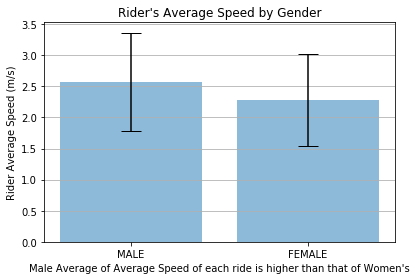

In [173]:
import matplotlib.pyplot as plt


genders = ['MALE', 'FEMALE']
x_pos = np.arange(2)
y = [
    df[df['gender'] == 1]['avg_speed'].mean()
    , df[df['gender'] == 2]['avg_speed'].mean()
]
error = [
    df[df['gender'] == 1]['avg_speed'].std()
    , df[df['gender'] == 2]['avg_speed'].std()
]
fig, ax = plt.subplots()
ax.bar(x_pos, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Rider Average Speed (m/s)')
ax.set_xlabel('Male Average of Average Speed of each ride is higher than that of Women\'s')
ax.set_xticks(x_pos)
ax.set_xticklabels(genders)
ax.set_title('Rider\'s Average Speed by Gender')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#### CAPTION: 
1. Notice that the Mean of average speed of each ride is higher for man
2. Also notice that the error bars that mark the standard deviation of each average-of-averages. Each gender's mean is included in each others 2SD interval. 
3. Therefore, I do not think it's likely that we would get a statistically significant result from this dataset.

#### Making the case more edge-of-the-seat-ish

##### Filtering data so that at most 7 minutes were spent riding, and the distance was greater than 500m.

In [174]:
df = __DATA_PROCESSED__[(__DATA_PROCESSED__.duration_sec < 60 * 7.0) & (__DATA_PROCESSED__['distance'] > 500)]
df.head(7)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,duration_sec,distance,avg_speed
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,360.0,560.934073,1.558150
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,360.0,917.694645,2.549152
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,180.0,601.322434,3.340680
13,332,1/1/2015 0:13,1/1/2015 0:18,361,Allen St & Hester St,40.716059,-73.991908,438,St Marks Pl & 1 Ave,40.727791,-73.985649,17342,Subscriber,1988.0,1,2015-01-01 00:13:00,300.0,1406.086594,4.686955
21,307,1/1/2015 0:18,1/1/2015 0:23,474,5 Ave & E 29 St,40.745168,-73.986831,476,E 31 St & 3 Ave,40.743943,-73.979661,18834,Subscriber,1962.0,1,2015-01-01 00:18:00,300.0,620.659455,2.068865
30,321,1/1/2015 0:23,1/1/2015 0:29,285,Broadway & E 14 St,40.734546,-73.990741,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,15777,Subscriber,1986.0,1,2015-01-01 00:23:00,360.0,1120.839084,3.113442
31,259,1/1/2015 0:23,1/1/2015 0:27,285,Broadway & E 14 St,40.734546,-73.990741,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21338,Subscriber,1986.0,1,2015-01-01 00:23:00,240.0,1120.839084,4.670163


In [175]:
i_want = ['gender', 'avg_speed']
df.drop([c for c in df.columns if c not in i_want], axis=1, inplace=True)
df.head(7)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,gender,avg_speed
1,1,1.558150
2,1,2.549152
3,1,3.340680
13,1,4.686955
21,1,2.068865
30,1,3.113442
31,1,4.670163


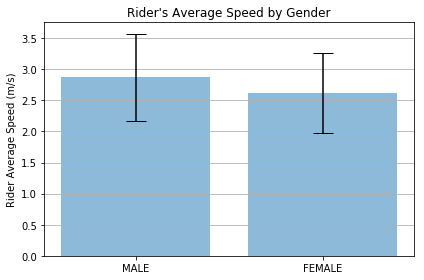

In [176]:
import matplotlib.pyplot as plt


genders = ['MALE', 'FEMALE']
x_pos = np.arange(2)
y = [
    df[df['gender'] == 1]['avg_speed'].mean()
    , df[df['gender'] == 2]['avg_speed'].mean()
]
error = [
    df[df['gender'] == 1]['avg_speed'].std()
    , df[df['gender'] == 2]['avg_speed'].std()
]
fig, ax = plt.subplots()
ax.bar(x_pos, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Rider Average Speed (m/s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(genders)
ax.set_title('Rider\'s Average Speed by Gender')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

# IDEA:
## Are men faster than women on bike?

# NULL HYPOTHESIS:
## Among male/female rides whose distance is greater than 500m and duration shorter than 420 seconds (7 minutes), The mean speed (total distance in meters divided by total duration in seconds) of men citibike riders is same or lower than the mean speed of women citibikers.

# _$H_0$_ : $AverageSpeed_{Men} - AverageSpeed_{Women} <= 0 $
# _$H_1$_ : $AverageSpeed_{Men} - AverageSpeed_{Women} > 0$

## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [177]:
### End of Duke's Notebook. 
### Happy Coding!